# DNA sequence analysis using NLP:

## Importing libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import PredefinedSplit, GridSearchCV

## Loading the dataset:

In [3]:
human_DNA = pd.read_table('human_data.txt')
human_DNA

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3
...,...,...
4375,ATGGAAGATTTGGAGGAAACATTATTTGAAGAATTTGAAAACTATT...,0
4376,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6
4377,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6
4378,ATGGGGCACCTGGTTTGCTGTCTGTGTGGCAAGTGGGCCAGTTACC...,6


## Exploratory Data Analysis

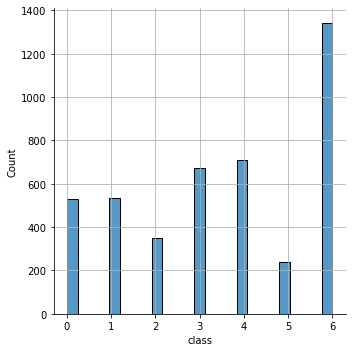

In [4]:
# Distribution of counts of different gene families:
sns.displot(data = human_DNA, x = 'class', bins = 25)
plt.grid()
plt.show()

### Above plot implies that our dataset is fairly balanced. Hence, there is no need for undersampling or oversampling.

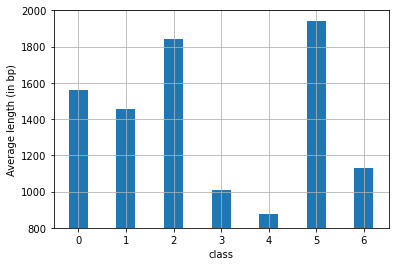

In [5]:
# Average length of DNA sequences in each gene family:
avg_len = []

for i in range(7):
    avg_len.append(floor(human_DNA['sequence'][human_DNA['class']==i].str.len().mean()))

plt.bar(x = [i for i in range(7)], height = avg_len, width = 0.4)
plt.grid()
plt.xlabel('class')
plt.ylabel('Average length (in bp)')
plt.ylim((800, 2000))
plt.show()

<Figure size 432x288 with 0 Axes>

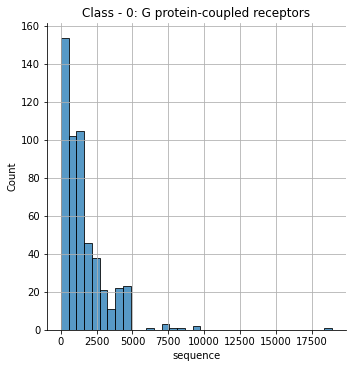

<Figure size 432x288 with 0 Axes>

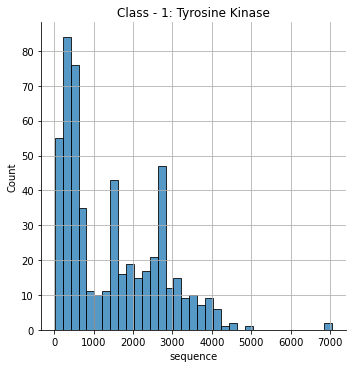

<Figure size 432x288 with 0 Axes>

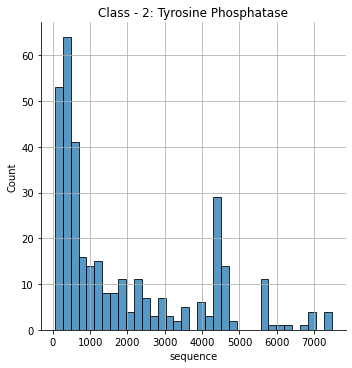

<Figure size 432x288 with 0 Axes>

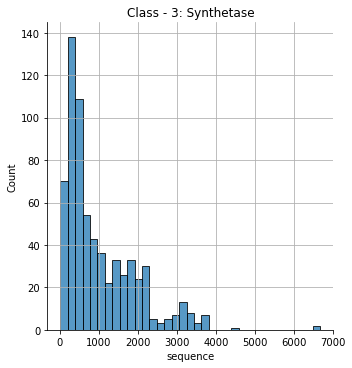

<Figure size 432x288 with 0 Axes>

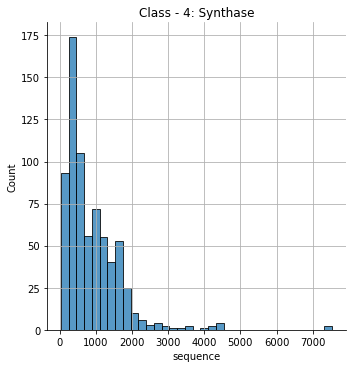

<Figure size 432x288 with 0 Axes>

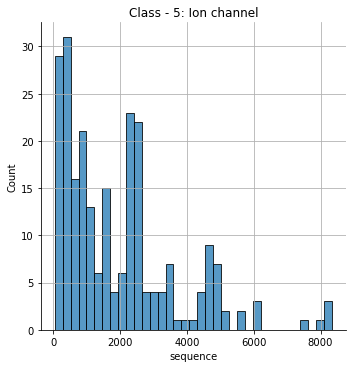

<Figure size 432x288 with 0 Axes>

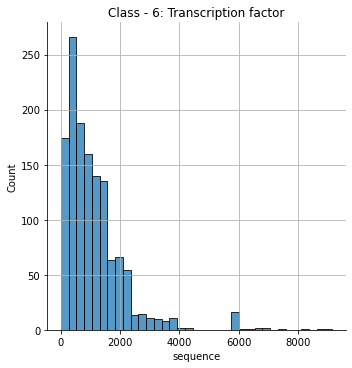

In [6]:
# Distributions of length of DNA sequences for each gene family:
gene_fams = {'0':'G protein-coupled receptors', '1':'Tyrosine Kinase', '2':'Tyrosine Phosphatase',
            '3': 'Synthetase', '4':'Synthase', '5':'Ion channel', '6':'Transcription factor'}

for i in range(7):
    plt.figure()
    sns.displot(data = human_DNA, x = human_DNA['sequence'][human_DNA['class']==i].str.len(), kind = 'hist', bins = 35)
    plt.grid()
    plt.title(f"Class - {i}: " + gene_fams[str(i)])

## Text preprocessing: 

### Description:

DNA and protein sequences can be thought of as the language of life. The language encodes instructions as well as functions for molecules found in all lifeforms. The sequence language comparison is the following: 
- Genome of a lifeform is analogous to a "book"
- Gene families as "chapters" and genes as "sentences" in the chapter 
- K-mers and peptides as "words" of each "sentence"
- Nucleotide bases and amino acids as "alphabets" of the language  

### Using k-mers counting approach to get vectors of uniform length

_**Method**:_ 
-  Take the long biological sequence and break it down into "words" of k-mer length each, also taking into account the overlap between different "words"
- For example, for "words" of length 6 (hexamers), "AAAAAATTTTTT" becomes: "AAAAAAA", "AAAATT", "AAATTT", "AATTTTT", "ATTTTT", "TTTTTT". Hence the given sequence is broken down into 6 "words" each of length 6
- "Word" length is arbitrary and needs to be tuned to suit the particular situation

Reference paper used: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0206409

In [7]:
# Forming "sentences" using k-mers as "words" from a given DNA sequence:
def k_mers_doc(sequence, bp = 6):
    
    token_list = [sequence[i:i+bp].lower() for i in range(len(sequence) - (bp-1))]
    return ' '.join(token_list)

In [8]:
human_DNA['doc'] = human_DNA.apply(lambda x: k_mers_doc(x['sequence']), axis = 1)
human_DNA

,sequence,class,doc
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,atgccc tgcccc gcccca ccccaa cccaac ccaact caac...
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,atgaac tgaacg gaacga aacgaa acgaaa cgaaaa gaaa...
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,atgcaa tgcaac gcaaca caacag aacagc acagca cagc...
...,...,...,...
4375,ATGGAAGATTTGGAGGAAACATTATTTGAAGAATTTGAAAACTATT...,0,atggaa tggaag ggaaga gaagat aagatt agattt gatt...
4376,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6,atgcag tgcagt gcagtc cagtcc agtcct gtcctt tcct...
4377,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6,atgcag tgcagt gcagtc cagtcc agtcct gtcctt tcct...
4378,ATGGGGCACCTGGTTTGCTGTCTGTGTGGCAAGTGGGCCAGTTACC...,6,atgggg tggggc ggggca gggcac ggcacc gcacct cacc...


In [9]:
# Dropping sequence column:
human_DNA = human_DNA.drop('sequence', axis = 1)
human_DNA

,class,doc
0,4,atgccc tgcccc gcccca ccccaa cccaac ccaact caac...
1,4,atgaac tgaacg gaacga aacgaa acgaaa cgaaaa gaaa...
2,3,atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...
3,3,atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...
4,3,atgcaa tgcaac gcaaca caacag aacagc acagca cagc...
...,...,...
4375,0,atggaa tggaag ggaaga gaagat aagatt agattt gatt...
4376,6,atgcag tgcagt gcagtc cagtcc agtcct gtcctt tcct...
4377,6,atgcag tgcagt gcagtc cagtcc agtcct gtcctt tcct...
4378,6,atgggg tggggc ggggca gggcac ggcacc gcacct cacc...


### Bag-of-words model:

In [10]:
# Using bigram model and selecting top 10,000 unique bigrams as features using Count Vectorizer technique:
Vectorizer = CountVectorizer(max_features = int(1e5), ngram_range = (2, 2))
X = Vectorizer.fit_transform(human_DNA['doc'])

In [11]:
# Feature list:
print(Vectorizer.get_feature_names())

['aaaaaa aaaaaa', 'aaaaaa aaaaac', 'aaaaaa aaaaag', 'aaaaaa aaaaat', 'aaaaac aaaaca', 'aaaaac aaaacc', 'aaaaac aaaacg', 'aaaaac aaaact', 'aaaaag aaaaga', 'aaaaag aaaagc', 'aaaaag aaaagg', 'aaaaag aaaagt', 'aaaaat aaaata', 'aaaaat aaaatc', 'aaaaat aaaatg', 'aaaaat aaaatt', 'aaaaca aaacaa', 'aaaaca aaacac', 'aaaaca aaacag', 'aaaaca aaacat', 'aaaacc aaacca', 'aaaacc aaaccc', 'aaaacc aaaccg', 'aaaacc aaacct', 'aaaacg aaacga', 'aaaacg aaacgc', 'aaaacg aaacgg', 'aaaacg aaacgt', 'aaaact aaacta', 'aaaact aaactc', 'aaaact aaactg', 'aaaact aaactt', 'aaaaga aaagaa', 'aaaaga aaagac', 'aaaaga aaagag', 'aaaaga aaagat', 'aaaagc aaagca', 'aaaagc aaagcc', 'aaaagc aaagcg', 'aaaagc aaagct', 'aaaagg aaagga', 'aaaagg aaaggc', 'aaaagg aaaggg', 'aaaagg aaaggt', 'aaaagt aaagta', 'aaaagt aaagtc', 'aaaagt aaagtg', 'aaaagt aaagtt', 'aaaata aaataa', 'aaaata aaatac', 'aaaata aaatag', 'aaaata aaatat', 'aaaatc aaatca', 'aaaatc aaatcc', 'aaaatc aaatcg', 'aaaatc aaatct', 'aaaatg aaatga', 'aaaatg aaatgc', 'aaaatg aaatg

## Training ML model on the dataset:

In [12]:
# Ground truth labels of the dataset:
labels = human_DNA.iloc[:, 0].values

In [13]:
# Splitting into training and validation set:
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size = 0.2, random_state = 42)

In [14]:
# Using Multinomial Naive Bayes model for classification:
clf_model = MNB() 
clf_model.fit(X_train, y_train)

MultinomialNB()

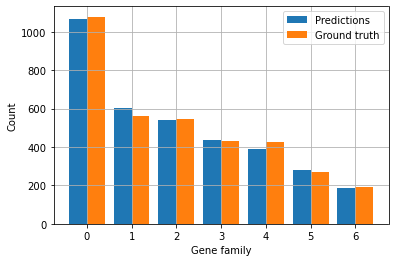

In [15]:
# Visualizing predictions for training set:
y_train_preds = clf_model.predict(X_train)
X_axis = np.arange(7)

plt.bar(X_axis-0.2, height = pd.Series(y_train_preds).value_counts(), width = 0.4, label = 'Predictions')
plt.bar(X_axis+0.2, height = pd.Series(y_train).value_counts(), width = 0.4, label = 'Ground truth')
plt.xticks(X_axis, X_axis)
plt.xlabel("Gene family")
plt.ylabel("Count")
plt.grid()
plt.legend()
plt.show()

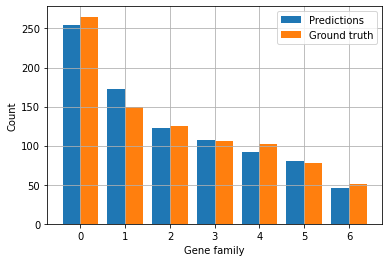

In [16]:
# Visualizing predictions for validation set:
y_val_preds = clf_model.predict(X_val)
X_axis = np.arange(7)

plt.bar(X_axis-0.2, height = pd.Series(y_val_preds).value_counts(), width = 0.4, label = 'Predictions')
plt.bar(X_axis+0.2, height = pd.Series(y_val).value_counts(), width = 0.4, label = 'Ground truth')
plt.xticks(X_axis, X_axis)
plt.xlabel("Gene family")
plt.ylabel("Count")
plt.grid()
plt.legend()
plt.show()

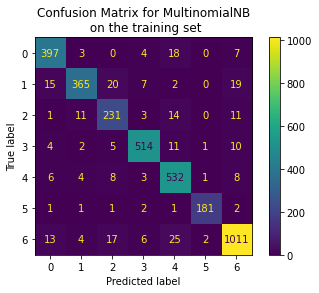

In [17]:
# Confusion matrix for the training set:
fig = ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_preds), display_labels = np.array([i for i in range(7)]))
fig.plot()
plt.title(f"Confusion Matrix for {clf_model.__class__.__name__}\n on the training set")
plt.show()

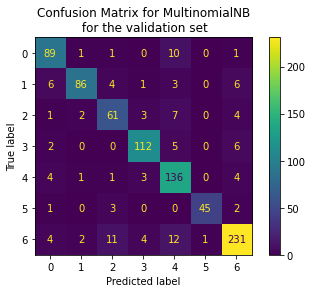

In [18]:
# Confusion matrix for the validation set:
fig = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_preds), display_labels = np.array([i for i in range(7)]))
fig.plot()
plt.title(f"Confusion Matrix for {clf_model.__class__.__name__}\n for the validation set")
plt.show()

In [19]:
# f1-scores for training and validation set:
print("Training set =", f1_score(y_train, y_train_preds, average = 'weighted'))
print("Validation set =", f1_score(y_val, y_val_preds, average = 'weighted'))

Training set = 0.9222043839970268
Validation set = 0.8684735151958002


### Since, validation error is significantly more than training error, our model overfits the training data. So, its necessary the model's hyperparameters for better accuracy

## Hyperparameter tuning:

### Tuning the hyperparameter alpha (additive smoothing parameter):

In [20]:
# Using predefined training and validation set:

# Creating a list where train data indices are -1 and validation data indices are 0
split_index = ([-1]*X_train.shape[0]) + ([0]*X_val.shape[0])

# Concatenating training and validation data:
X_total = np.row_stack((X_train.toarray(), X_val.toarray()))
y_total = np.concatenate((y_train, y_val), axis = 0)

# Using the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

In [21]:
parameters = [{'alpha':np.linspace(0.1, 1.0, 10)}]

grid_search = GridSearchCV(estimator = clf_model,
                           param_grid = parameters,
                           scoring = 'f1_weighted', 
                           cv = pds,
                           n_jobs = -1)

grid_search.fit(X_total, y_total)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid=[{'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}],
             scoring='f1_weighted')

In [22]:
best_parameters = grid_search.best_params_
print("Best value of hyperparameter:", best_parameters)

Best value of hyperparameter: {'alpha': 0.1}


## Training the Multinomial Naive Bayes model using best value of hyperparameter:

In [23]:
clf_model_best = MNB(alpha = 0.1) 
clf_model_best.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

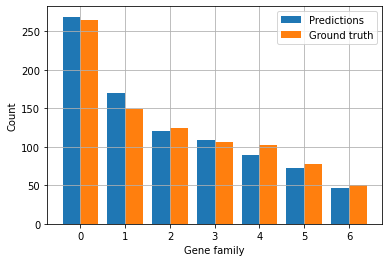

In [25]:
# Visualizing predictions for validation set:
y_val_preds_best = clf_model_best.predict(X_val)
X_axis = np.arange(7)

plt.bar(X_axis-0.2, height = pd.Series(y_val_preds_best).value_counts(), width = 0.4, label = 'Predictions')
plt.bar(X_axis+0.2, height = pd.Series(y_val).value_counts(), width = 0.4, label = 'Ground truth')
plt.xticks(X_axis, X_axis)
plt.xlabel("Gene family")
plt.ylabel("Count")
plt.grid()
plt.legend()
plt.show()

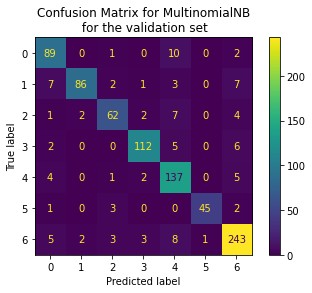

In [26]:
# Confusion matrix for the validation set:

fig = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_preds_best), display_labels = np.array([i for i in range(7)]))
fig.plot()
plt.title(f"Confusion Matrix for {clf_model.__class__.__name__}\n for the validation set")
plt.show()

In [27]:
# f1-score for validation set:
print("Validation set =", f1_score(y_val, y_val_preds_best, average = 'weighted'))

Validation set = 0.8839201711715114


## Testing the trained model on chimpanzee DNA sequences:

In [28]:
# Loading the dataset:
chimp_DNA = pd.read_table('chimp_data.txt')
chimp_DNA

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6
...,...,...
1677,ATGCTGAGCGGAGCGGCTGGGGCTGCGCGGCGTGGCGGAGCAGCGC...,5
1678,ATGCTGAGCGGAGCGGCTGGGGCTGCGCGGCGTGGCGGAGCAGCGC...,5
1679,ATGAAGCGACCCAAGGAGCCGAGCGGCTCCGACGGGGAGTCCGACG...,6
1680,ATGACTGGAACCCCAAAGACTCAAGAAGGAGCTAAAGATCTTGAAG...,3


In [29]:
# Preprocessing chimp DNA sequences:
chimp_DNA['doc'] = chimp_DNA.apply(lambda x: k_mers_doc(x['sequence']), axis = 1)
chimp_DNA = chimp_DNA.drop('sequence', axis = 1)
X_test_chimp = Vectorizer.transform(chimp_DNA['doc'])
y_test_chimp = chimp_DNA['class'].values

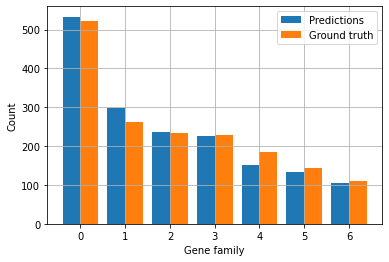

In [30]:
# Visualizing predictions for chimpanzee test set:
y_chimp_preds = clf_model_best.predict(X_test_chimp)
X_axis = np.arange(7)

plt.bar(X_axis-0.2, height = pd.Series(y_chimp_preds).value_counts(), width = 0.4, label = 'Predictions')
plt.bar(X_axis+0.2, height = pd.Series(y_test_chimp).value_counts(), width = 0.4, label = 'Ground truth')
plt.xticks(X_axis, X_axis)
plt.xlabel("Gene family")
plt.ylabel("Count")
plt.grid()
plt.legend()
plt.show()

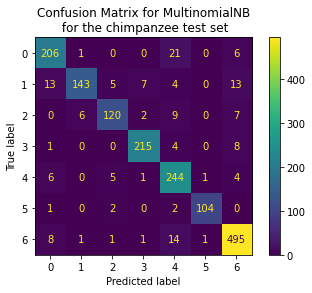

In [31]:
# Confusion matrix for the chimpanzee test set:

fig = ConfusionMatrixDisplay(confusion_matrix(y_test_chimp, y_chimp_preds), display_labels = np.array([i for i in range(7)]))
fig.plot()
plt.title(f"Confusion Matrix for {clf_model.__class__.__name__}\n for the chimpanzee test set")
plt.show()

In [32]:
# f1-score for chimpanzee test set:
print("Chimpanzee test set =", f1_score(y_test_chimp, y_chimp_preds, average = 'weighted'))

Chimpanzee test set = 0.9074962580500096


### Testing the trained model on dog DNA sequences:

In [37]:
# Loading the dataset:
dog_DNA = pd.read_table('dog_data.txt')
dog_DNA

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0
...,...,...
815,ATGGTCGGTCCGGAGAAGGAGCAGAGCTGGATCCCTAAGATCTTCA...,5
816,ATGGCGGCGACGGTGGCTGCGGCGGCCGCCGACGCGGGGCCGGGGG...,6
817,ATGAGCTCGGCCGACAAGGCCCGGGTGGGGCCCGCGGCCGACGGGC...,6
818,GCCCCGAGGATGGGCAGGGTCCCGCTGGCCTGGTGCTTGGCGCTGT...,1


In [38]:
# Preprocessing dog DNA sequences:
dog_DNA['doc'] = dog_DNA.apply(lambda x: k_mers_doc(x['sequence']), axis = 1)
dog_DNA = dog_DNA.drop('sequence', axis = 1)
X_test_dog = Vectorizer.transform(dog_DNA['doc'])
y_test_dog = dog_DNA['class'].values

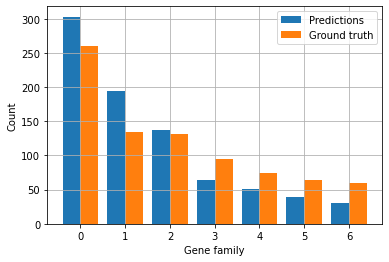

In [39]:
# Visualizing predictions for test set:
y_dog_preds = clf_model_best.predict(X_test_dog)
X_axis = np.arange(7)

plt.bar(X_axis-0.2, height = pd.Series(y_dog_preds).value_counts(), width = 0.4, label = 'Predictions')
plt.bar(X_axis+0.2, height = pd.Series(y_test_dog).value_counts(), width = 0.4, label = 'Ground truth')
plt.xticks(X_axis, X_axis)
plt.xlabel("Gene family")
plt.ylabel("Count")
plt.grid()
plt.legend()
plt.show()

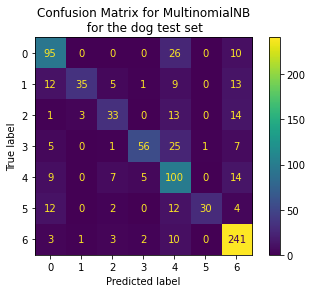

In [40]:
# Confusion matrix for the chimpanzee test set:

fig = ConfusionMatrixDisplay(confusion_matrix(y_test_dog, y_dog_preds), display_labels = np.array([i for i in range(7)]))
fig.plot()
plt.title(f"Confusion Matrix for {clf_model.__class__.__name__}\n for the dog test set")
plt.show()

In [41]:
# f1-score for dog test set:
print("Dog test set =", f1_score(y_test_dog, y_dog_preds, average = 'weighted'))

Dog test set = 0.7153003798857269


### Results:

- From the f1-scores of chimpanzee and dog DNA sequences, we can conclude human genome is very similar to that of chimpanzee implying the possible existence of common ancestor
- On the contrary, dog's genome significantly differs from that of a human. However, there does exist some similarities between both genomes. This can be observed in the case of the gene family of Tyrosine Phosphatase, where there are multiple instances of correct classification.